In [ ]:
import numpy as np
import torch
import sys
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils import data
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision
import matplotlib.pyplot as plt
import time
from collections import namedtuple

from torchvision import transforms, datasets, models

cuda = torch.cuda.is_available()
cuda

True

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  #normalize to -1,1
trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


(32, 32, 3)
bird


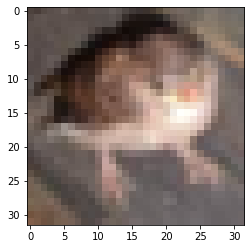

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = images[0].numpy ()
img = img / 2 + 0.5    ## normalization img * std + mean
img = np.transpose(img, (1, 2, 0)) ## change permutation of trnsprose 
                                    ## second, third , first dim
print(img.shape)
plt.imshow(img)
print(classes[labels[0]])

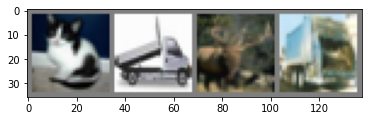

       cat      truck       deer      truck


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

Same model as MNIST to show why fails


In [ ]:
#Defining a Simple MLP model
class MyModel(nn.Module):
  def __init__(self,size_list):
    super(MyModel, self).__init__()
    self.size_list = size_list
    layers = []
    for i in range(len(size_list)-2):
      layers.append(nn.Linear(size_list[i],size_list[i+1]))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout())
    layers.append(nn.Linear(size_list[-2],size_list[-1]))
    self.net = nn.Sequential(*layers)
    # self.layers  = nn.ModuleList(self.layers)
  
  def forward(self,x):
    return self.net(x.float())

In [ ]:
##Creating own dataset example
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self,index):
        X = self.X[index].astype(float).reshape(-1)
        Y = self.Y[index]
        return X,Y

In [ ]:
train_dataset = MyDataset(trainset.data, trainset.targets)
test_dataset = MyDataset(testset.data, testset.targets)

train_loader_args = dict(shuffle=True, batch_size=256, pin_memory=True) if cuda\
                    else dict(shuffle=True, batch_size=64)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

test_loader_args = dict(shuffle=False, batch_size=256, pin_memory=True) if cuda\
                    else dict(shuffle=False, batch_size=1)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


In [ ]:
model = MyModel([3072,256,128,64,10])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
model.to(device)
print(model)

MyModel(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:
def train_epoch(model,train_loader,criterion,optimizer):
  model.train()
  running_loss = 0.0
  start_time = time.time()
  for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
  end_time = time.time()
  running_loss /= len(train_loader)
  print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
  return running_loss
  

In [ ]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.to(device)
            
            outputs = model(data)
            #_, predicted = torch.max(outputs, 1)
            #_, predicted = torch.max(outputs.data, 1)
            predicted = torch.argmax(outputs,dim = 1)

            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()
            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [ ]:
n_epochs = 15
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model, test_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    print('='*20)

Training Loss:  3.6573377409759833 Time:  1.927692174911499 s
Testing Loss:  2.302954024076462
Testing Accuracy:  10.0 %
Training Loss:  2.3029813924614264 Time:  1.5928914546966553 s
Testing Loss:  2.302621233463287
Testing Accuracy:  10.0 %
Training Loss:  2.3028185841988544 Time:  1.610769510269165 s
Testing Loss:  2.302607703208923
Testing Accuracy:  9.99 %
Training Loss:  2.3027733807661095 Time:  1.5753650665283203 s
Testing Loss:  2.3026321113109587
Testing Accuracy:  10.0 %
Training Loss:  2.3027874243502713 Time:  1.568119764328003 s
Testing Loss:  2.302591395378113
Testing Accuracy:  10.0 %
Training Loss:  2.3026817526136125 Time:  1.78926420211792 s
Testing Loss:  2.3025951087474823
Testing Accuracy:  10.0 %
Training Loss:  2.302739464506811 Time:  1.6461181640625 s
Testing Loss:  2.302552378177643
Testing Accuracy:  10.0 %
Training Loss:  2.3027468798111896 Time:  1.6544511318206787 s
Testing Loss:  2.302536869049072
Testing Accuracy:  10.0 %
Training Loss:  2.3027230975579

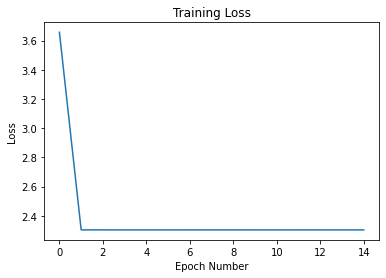

In [ ]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Train_loss)

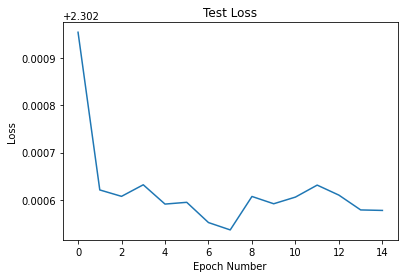

In [ ]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(Test_loss)

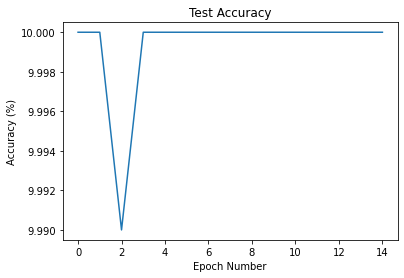

In [ ]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(Test_acc)